#### Pakkar

In [1]:
# Our Libraries 
from ourModules import text_processor
from ourModules import toxic_comment_Classifier

/Users/numisteinn/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [1]:
# Libraries ---------------------------------
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction import stop_words
import string
from tensorflow.python.keras.preprocessing import text, sequence
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Dropout
from tensorflow.python.keras.optimizers import Adadelta
import scipy.sparse
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import warnings; 
# # %tensorflow_version 1.x
# import tensorflow
# print(tensorflow.__version__)
import tensorflow as tf

/Users/numisteinn/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
tf.compat.v1.disable_eager_execution()

#### Innlestur gagna

In [160]:
train_data = pd.read_csv('data/train.csv',delimiter=',')
train_data.drop('id',axis=1,inplace=True) # Id er gagnslaust til ad spa
# test_labeled_data = pd.read_csv('data/test_labels.csv',delimiter=',') # Will most likely not be used

test_data_big = pd.read_csv('data/test_labels.csv',delimiter=',')

In [164]:
print(display(test_data_big.sample(6)))

X_test_data_big = train_data.drop(columns = cols[1:])
y_test_data_big = train_data.drop(columns = cols[:1])
print(X_test_data_big.shape)
print(y_test_data_big.shape)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
86638,9094af5e4a290080,0,0,0,0,0,0
14863,18f84a2d9a96e0f6,-1,-1,-1,-1,-1,-1
25974,2b47b0ec59f64c70,-1,-1,-1,-1,-1,-1
86559,906cf704ccb7bfb8,0,0,0,0,0,0
91130,97f18d425e7bd3be,-1,-1,-1,-1,-1,-1
130239,d9a9aa0528038618,-1,-1,-1,-1,-1,-1


None
(159571, 1)
(159571, 6)


### Gagnasettið
Hér má sjá gagnasettið sem við þjálfum módelið á. Við erum með comment_text og hann er búið að greina (0 eða 1) hvort hann sé toxic, severe_toxic, obscene, threat, insult eða identity_hate.

In [6]:
# Nota þetta til að testa loka módelið
cols = list(train_data)
X_train_data = train_data.drop(columns = cols[1:])
y_train_data = train_data.drop(columns = cols[:1])

# 80/20 train/test split
# Mögulega þarf að nota sklearn.cross_validation.StratifiedShuffleSplit frekar til að halda svipuðu 
X_train, X_test, y_train, y_test = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=12)
X_train_np, X_test_np, y_train_np, y_test_np = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()


In [157]:
print(train_data.shape)
print(display(train_data.sample(6)))

(159571, 7)


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
22877,Go and tell Elonka to learn how to be an Admin!,0,0,0,0,0,0
15626,When I said “There is no legitimate controvers...,0,0,0,0,0,0
17401,"""::Scalhotrod, your """"what ifs"""" notation is n...",0,0,0,0,0,0
68384,after having also offered his services to othe...,0,0,0,0,0,0
91757,I do not support Wikipedia and have now indica...,0,0,0,0,0,0
42524,"Vandalism\nPlease do not blank pages, as you d...",0,0,0,0,0,0


None


Data subsampling succsessful!
Reducing dimensions...
Plotting PCA projection...


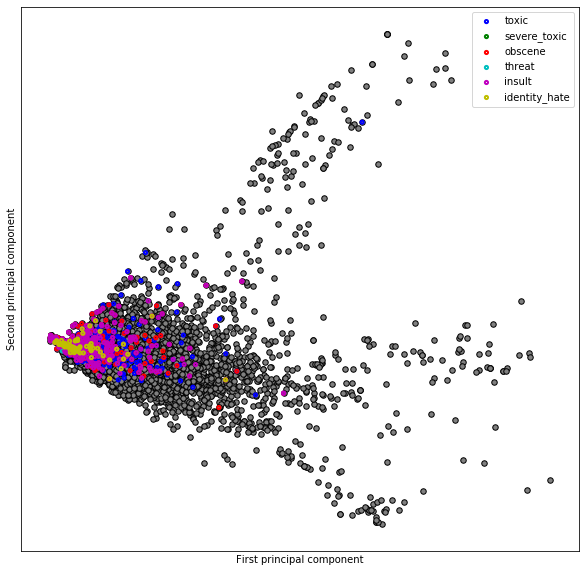

In [887]:
def plot_pca(x_data, y_data, colum_names):
    # PCA reynir að halda punktum langt fra hvor öðrum langt frá hvor öðrum
    print("Reducing dimensions...")
    x_2d = PCA(n_components=2).fit_transform(x_data.todense())

    print("Plotting PCA projection...")
    min_x = np.min(x_2d[:, 0])
    max_x = np.max(x_2d[:, 0])

    min_y = np.min(x_2d[:, 1])
    max_y = np.max(x_2d[:, 1])

    colors_ = ['b', 'g', 'r', 'c', 'm', 'y']
    plt.figure(figsize=(10, 10))
    #plots all the dots
    plt.scatter(x_2d[:, 0], x_2d[:, 1], s=30, c='gray', edgecolors=(0, 0, 0))
    for i in range(len(colum_names)):
        label_ = np.where(y_data[:, i])
        # plots lables as empty coloured circles, each dot can have multiple labels
        plt.scatter(x_2d[label_, 0], x_2d[label_, 1], s=10, edgecolors=colors_[i],
                facecolors='none', linewidths=2, label=colum_names[i])
    plt.xticks(())
    plt.yticks(())

    plt.xlim(min_x - .5 * max_x, max_x + .5 * max_x)
    plt.ylim(min_y - .5 * max_y, max_y + .5 * max_y)

    plt.xlabel('First principal component')
    plt.ylabel('Second principal component')
    plt.legend(loc="upper right")
    plt.autoscale()
    plt.show()
    
# Dimensionality reduction
train_size = 10000

#tekur um sec þús train size
X_train_reduced, y_train_reduced = data_subsample_asserts_two_classes(X_train_np, y_train_np, train_size)
X_train_reduced, vectorizer = vectorize_data(X_train_reduced)
plot_pca(X_train_reduced, y_train_reduced, cols[1:])


Sjáum frá grafinu og greinilegt er að klasarnir eru nálægt hvor öðrum

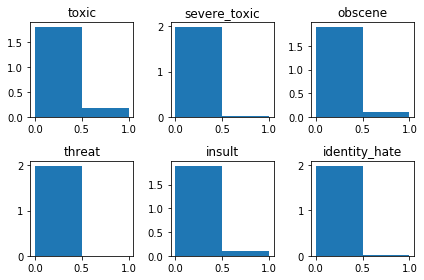

Number of instances marked with toxic: 	 12143/127656 or 9.51%
Number of instances marked with severe_toxic: 	 1265/127656 or 0.99%
Number of instances marked with obscene: 	 6714/127656 or 5.26%
Number of instances marked with threat: 	 387/127656 or 0.30%
Number of instances marked with insult: 	 6275/127656 or 4.92%
Number of instances marked with identity_hate: 	 1117/127656 or 0.88%


In [7]:
# Visualize distribution of y
n_bins = 2
fig, axes = plt.subplots(nrows=2, ncols=3)
axs = axes.flatten()
i = 0
for col in cols[1:]:
    axs[i].hist(y_train[col], n_bins, density=True, histtype='bar')
    axs[i].set_title(col)
    i +=1
fig.tight_layout()
plt.show()
# Notice skewed dataset
for col in cols[1:]:
    cnt = np.count_nonzero(y_train[col])
    print('Number of instances marked with {}: \t {}/{} or {:.2%}'.format(col, cnt,
                                                                    y_train_np.shape[0], cnt/y_train_np.shape[0]) )

In [116]:
def get_row_accuracy(y_true, y_pred):
    acc = np.sum(y_true == y_pred, axis = 1)
    return np.average(np.where(acc == 6, 1, 0), axis = 0)

n,m = y_train_np.shape
y_pred_mat = np.zeros((n,m))

rowindx, colindx = np.nonzero(y_train_np)
rwi = np.unique(rowindx)
# print('Number of rows with at least one none-zero value ', len(rwi))
# non_zero_y_train = y_train_np[rwi]
# # for i in range(m):
# #     print('All-zero guess accuracy on data for {} is: {:.2%}'.format(cols[i+1], np.average(y_pred == y_train_np[:, i])))
# #     print('All-zero guess accuracy for {} but all-zero-rows removed is: {:.2%}'.format(cols[i+1],
# #                                                                 np.average(y_pred[rwi] == non_zero_y_train[:, i])))
# #     print('-'*100)

print('All-zero guess row accuracy on data is: {:.2%}'.format(get_row_accuracy(y_train_np, y_pred_mat)))
mat = confusion_matrix(y_train_np.ravel(), y_pred_mat.ravel())
fpr, tpr, _ = roc_curve(y_train_np.ravel(), y_pred_mat.ravel())
roc_auc = auc(fpr, tpr)
print(roc_auc)

All-zero guess row accuracy on data is: 89.89%
[0. 1.]
[0. 1.]
0.5


### State Vector Machine / Baseline Model




Lets build our first model. We start by making a simple SVM, which is widely regarded as one of the best text classification algorithms. This baseline classifier which treats the labels independently by training a binary classifier on each label separately. This initial model does not implement multilable classifaction in the best way nor does it take into account the skewed data.

In [10]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

def plot_precision_recall(recall, precision, average_param, average_precision, no_skill):
    plt.figure()

    plt.step(recall[average_param], precision[average_param], where='post', label='Our model')
    plt.step(no_skill[1], no_skill[0], linestyle='--', where='post', label='Random guess')

#     plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='All-zero guess')
    plt.xlabel('Recall/sensitivity')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(
        'Average precision score, {}-averaged over all classes: AP={:0.2f}'
        .format(average_param, average_precision[average_param]))
    plt.show()
    
def calc_precision_recall(y_true, y_scores, average_param = "micro", y_pred_ = None ):
    # Dæmi um notkun calc_precision_recall(y_test_np, y_scores, y_pred_ = y_test_pred)
    # y_scores is the decision function 
    # For each class
    # average_param has to be one of (None, 'micro', 'macro', 'weighted', 'samples')
    # micro = Calculate metrics globally by considering each element of the label indicator matrix as a label
    # macro = reiknar average_precision_score fyrir hvern label (hér: toxic...) og tekur óvigtað meðaltal
    # Ættum helst að nota micro held ég
    # y_scores er decision function sem segir hvoru megin (og hve langt frá) við aðskilnaðarplanið sem 
    # classfierinn býr til
    # no_skill baseline classifier giskar randomly
    # betra að nota random gisk hérna því all-zero gisk gefur 0 precision
    if y_pred_ is not None:
        # calculate F1 score
        f1 = f1_score(y_true, y_pred_, average = average_param)
        auc = roc_auc_score(y_true, y_scores, average = average_param)
        print("F1 score: {:.3f}, AUC score: {:.3f}".format(f1, auc))
        
    r_model = np.random.randint(2, size=len(y_true.ravel()))
    no_skill = precision_recall_curve(y_true.ravel(), r_model)
    
    precision = dict()
    recall = dict()
    average_precision = dict()
#     for i in range(y_true.shape[1]):
#         precision[i], recall[i], _ = precision_recall_curve(y_true[:, i],
#                                                             y_scores[:, i])
#         average_precision[i] = average_precision_score(y_true[:, i], y_scores[:, i])
    # A "micro-average": quantifying score on all classes jointly
    precision[average_param], recall[average_param], _ = precision_recall_curve(y_true.ravel(),
        y_scores.ravel())

    average_precision[average_param] = average_precision_score(y_true, y_scores,
                                                         average=average_param)
    
    plot_precision_recall(recall, precision, average_param, average_precision, no_skill)
    
# y_scores = clf.decision_function(vectorizer.transform(X_test_np.ravel()))
# calc_precision_recall(y_test_np, y_scores_linear, y_pred_ = y_pred_linear)
# plot_prec_recall(y_test_np, y_scores_linear, y_pred_linear, label_='Linear SVM model')

In [62]:
def plot_conf_mat(mat, cmap_="OrRd" ):
    tn, fp, fn, tp  = mat.ravel()
    print('-'*50)
    print("TN: {}\t FP: {} \nFN: {}\t TP: {}".format(tn, fp, fn, tp))
    print("The micro averaged sensitivity/recall is: {:.2%}".format(tp/(tp+fn)))
    print("The micro averaged specificity is: {:.2%}".format(tn/(tn+fp)))
    print("The micro averaged precision is: {:.2%}".format(tp/(tp+fp)))
    print('-'*50)
    ax = sn.heatmap(mat, annot=True, fmt="d", cmap=cmap_)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    # Lætur tölurnar vera í miðjum kassanum
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()
    
def calc_scores(y_true_, y_pred_):
    mats = multilabel_confusion_matrix(y_true_, y_pred_)
    n = len(mats)
    recall = 0; specificity = 0; precision = 0
    for mat in mats:
        tn, fp, fn, tp  = mat.ravel()
        recall += tp/(tp+fn)
        specificity += tn/(tn+fp)
        precision += tp/(tp+fp)
        
    print('-'*50)
    print("The macro averaged sensitivity/recall is: {:.2%}".format(recall/n))
    print("The macro averaged specificity is: {:.2%}".format(specificity/n))
    print("The macro averaged precision is: {:.2%}".format(precision/n))
    print('-'*50)



def vectorize_data(X_train_):
    vectorizer = CountVectorizer( max_df=0.95, min_df=100, max_features = None, stop_words='english')
    tfidf_transformer = TfidfTransformer()
    X_train_counts = vectorizer.fit_transform(X_train_.ravel())
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    return X_train_tfidf, vectorizer


In [12]:

# subsamples the data but makes sure all y columns include 2 classes
def data_subsample_asserts_two_classes(X, y, n):
    # Select a random subset of the training data
    max_tries = 15
    tries = 0
    while tries < max_tries:
        perm = np.random.permutation(len(y))
        X_sub=X[perm[0:n],:]
        y_sub=y[perm[0:n]]
        count = 0
        length = y_sub.shape[1]
        for i in range(length):
            # Make sure all columns have 2 classes
            if len(np.unique(y_sub[:,i])) < 2:
                break
            if i == (length-1):
                print('Data subsampling succsessful!')
                return X_sub, y_sub
        tries += 1
#         print("Data subsampling failed in {} try. Trying again.".format(tries) )
#         print('-'*100)
    print("Data subsampling failed in {} tries".format(max_tries))
    return 0,0


In [13]:

def plot_acc_params(param, train_acc_, val_acc_, param_name, title):
    plt.plot(param, train_acc_,label='Training accuracy')
    plt.plot(param, val_acc_,label='Validation accuracy')
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


# Utility function to move the midpoint of a colormap to be around
# the values of interest.
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

def plot_heatmap(data_matrix, title, xlabel, ylabel, x_values, y_values, vmin_, midpoint_):
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(data_matrix, interpolation='nearest', cmap=plt.cm.seismic,
               norm=MidpointNormalize(vmin=vmin_, midpoint=midpoint_))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    
    
    plt.xticks(np.arange(len(x_values)), x_values, rotation=45)
    plt.yticks(np.arange(len(y_values)), y_values)
    plt.title(title)
    plt.show()


In [82]:
def find_best_SVM_params(Cs, gammas, kernel_, xtrain, ytrain, xval, yval):
    training_acc = np.zeros(len(Cs))
    val_acc = np.zeros(len(Cs))
    # ignores the gamma values if linear
    if kernel_ != 'linear':
        training_acc = np.zeros((len(Cs), len(gammas)))
        val_acc = np.zeros((len(Cs), len(gammas)))
    
    for i in range(len(Cs)):
        print("c: ", Cs[i])
        if kernel_ != 'linear':
            for j in range(len(gammas)):
                print("gamma: ", gammas[j], end =" ")
                clf = OneVsRestClassifier(SVC(gamma=gammas[j], C = Cs[i], kernel = kernel_, 
                                              class_weight = 'balanced'))
                clf.fit(xtrain, ytrain)
#                 val_acc[i, j] = get_row_accuracy(yval, clf.predict(xval))

                y_scores_val = clf.decision_function(xval)
                y_scores_train = clf.decision_function(xtrain)
                val_acc[i, j] = roc_auc_score(yval, y_scores_val, average = 'macro')
#                 training_acc[i, j] = get_row_accuracy(ytrain, clf.predict(xtrain))
                training_acc[i]  = roc_auc_score(ytrain, y_scores_train, average = 'macro')
            print()
        else:
            clf = OneVsRestClassifier(SVC(C = Cs[i], kernel = kernel_, 
                                          class_weight = 'balanced'))
            clf.fit(xtrain, ytrain)
            y_scores_ = clf.decision_function(xval)
#             val_acc[i] = get_row_accuracy(yval, clf.predict(xval))
            y_scores_val = clf.decision_function(xval)
            y_scores_train = clf.decision_function(xtrain)
            val_acc[i]  = roc_auc_score(yval, y_scores_val, average = 'macro')
            training_acc[i]  = roc_auc_score(ytrain, y_scores_train, average = 'macro')

#             training_acc[i] = get_row_accuracy(ytrain, clf.predict(xtrain))
#     print('Train acc \n', training_acc)
#     print('Validation acc \n', val_acc)
    return training_acc, val_acc


In [83]:
%%time
X_train_reduced, y_train_reduced = data_subsample_asserts_two_classes(X_train_np, y_train_np, 2000)
print("Number of training instances: ", X_train_reduced.shape[0])

# Bag of words approach
# CountVectorizer has the benefit of producing a sparse representation of the counts 
vectorizer = CountVectorizer( max_df=0.95, min_df=2, max_features = None, stop_words='english')
tfidf_transformer = TfidfTransformer()

X_train_counts = vectorizer.fit_transform(X_train_reduced.ravel())
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# Rough search for a good estimate of C and gamma
x_test_unrvld = vectorizer.transform(X_test_np.ravel())

C = 0.01* np.power(10,np.arange(5))
gamma = 1/np.power(10,np.arange(4))

accs = { 'val_acc': {'rbf': np.zeros((len(C), len(gamma))),
                     'linear': np.zeros(len(C)) },
        'train_acc': {'rbf': np.zeros((len(C), len(gamma))),
                     'linear': np.zeros(len(C)) } 
       }
kernels = ['rbf', 'linear']
for kernel in kernels:
    print('-'*100)
    print('Using kernel ', kernel)
    print('Testing parameters, C: {},\ngamma: {}'.format(C, gamma))
    tA, vA = find_best_SVM_params(C, gamma, kernel,
                                     X_train_tfidf, y_train_reduced,
                                     x_test_unrvld, y_test_np)
    accs['train_acc'][kernel] = tA
    accs['val_acc'][kernel] = vA

rbfacc = accs['val_acc']['rbf']; linacc = accs['val_acc']['linear']
Cind, gammaind = np.unravel_index(np.argmax(rbfacc, axis=None), rbfacc.shape)
print('For rbf kernal')
rbfOptparam = C[Cind], gamma[gammaind]
print("Optimal combination is,  C: {}, gamma: {}".format(rbfOptparam[0], rbfOptparam[1]))
print("Giving the validation AUC: {:.2%}".format(rbfacc[Cind, gammaind]))

Cindex = np.argmax(linacc)
linearOptC = C[Cindex]
print('For linear kernal')
print("Optimal C is: {}".format(linearOptC))
print("Giving the validation AUC: {:.2%}".format(linacc[Cindex]))

Data subsampling succsessful!
Number of training instances:  2000
----------------------------------------------------------------------------------------------------
Using kernel  rbf
Testing parameters, C: [1.e-02 1.e-01 1.e+00 1.e+01 1.e+02],
gamma: [1.    0.1   0.01  0.001]
c:  0.01
gamma:  1.0 gamma:  0.1 gamma:  0.01 gamma:  0.001 
c:  0.1
gamma:  1.0 gamma:  0.1 gamma:  0.01 gamma:  0.001 
c:  1.0
gamma:  1.0 gamma:  0.1 gamma:  0.01 gamma:  0.001 
c:  10.0
gamma:  1.0 gamma:  0.1 gamma:  0.01 gamma:  0.001 
c:  100.0
gamma:  1.0 gamma:  0.1 gamma:  0.01 gamma:  0.001 
----------------------------------------------------------------------------------------------------
Using kernel  linear
Testing parameters, C: [1.e-02 1.e-01 1.e+00 1.e+01 1.e+02],
gamma: [1.    0.1   0.01  0.001]
c:  0.01
c:  0.1
c:  1.0
c:  10.0
c:  100.0
For rbf kernal
Optimal combination is,  C: 1.0, gamma: 0.001
Giving the validation AUC: 89.53%
For linear kernal
Optimal C is: 0.01
Giving the validation AUC

For rbf kernal
Optimal combination is,  C: 1.0, gamma: 0.001
Giving the validation AUC: 89.53%
For linear kernal
Optimal C is: 0.01
Giving the validation AUC: 89.17%


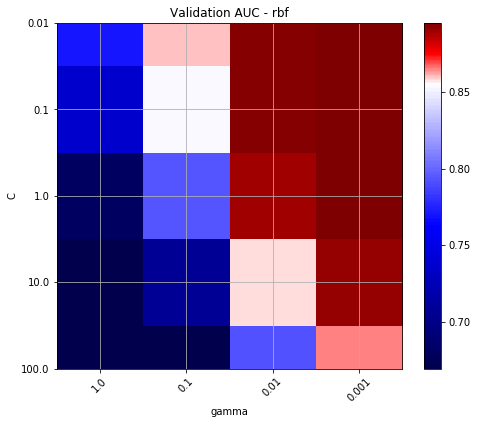

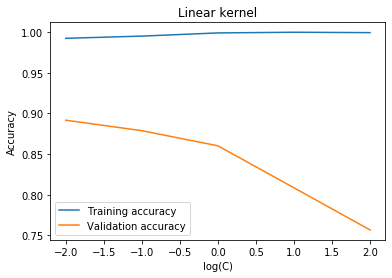

In [84]:
rbfacc = accs['val_acc']['rbf']; linacc = accs['val_acc']['linear']
Cind, gammaind = np.unravel_index(np.argmax(rbfacc, axis=None), rbfacc.shape)
print('For rbf kernal')
rbfOptparam = C[Cind], gamma[gammaind]
print("Optimal combination is,  C: {}, gamma: {}".format(rbfOptparam[0], rbfOptparam[1]))
print("Giving the validation AUC: {:.2%}".format(rbfacc[Cind, gammaind]))

linearOptC = C[np.argmax(linacc)]
print('For linear kernal')
print("Optimal C is: {}".format(linearOptC))
print("Giving the validation AUC: {:.2%}".format(linacc[Cindex]))

plot_heatmap(rbfacc, 'Validation AUC - rbf', 'gamma', 'C', gamma, C,
             np.min(rbfacc) , np.median(rbfacc))
plot_acc_params(np.log10(C), accs['train_acc']['linear'], accs['val_acc']['linear'], 'log(C)', 'Linear kernel')
plot_acc_params(C, accs['train_acc']['linear'], accs['val_acc']['linear'], 'C', 'Linear kernel')


Training size 3000
Using optimal C: 0.01
Data subsampling succsessful!
Test accuracy on linear kernel 84.19%
micro-averaged scores over all classes
F1 score: 0.501, 
AUC score: 0.931
--------------------
macro-averaged scores over all classes
F1 score: 0.421, 
AUC score: 0.946
--------------------


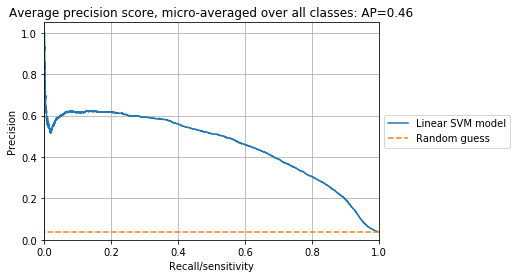

--------------------------------------------------
TN: 176523	 FP: 7770 
FN: 2189	 TP: 5008
The micro averaged sensitivity/recall is: 69.58%
The micro averaged specificity is: 95.78%
The micro averaged precision is: 39.19%
--------------------------------------------------


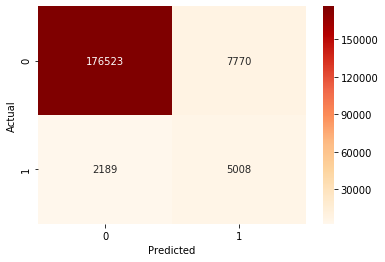

--------------------------------------------------
The macro averaged sensitivity/recall is: 37.27%
The macro averaged specificity is: 84.56%
The macro averaged precision is: 12.69%
--------------------------------------------------


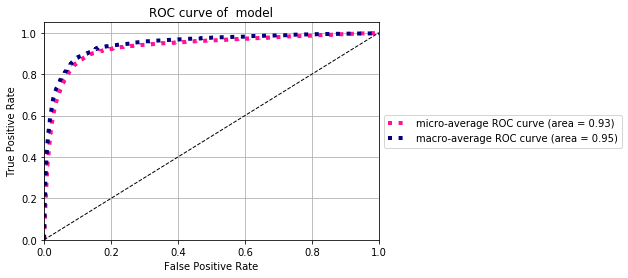

CPU times: user 14min 56s, sys: 4.67 s, total: 15min 1s
Wall time: 17min 54s


In [86]:
%%time

# Tekur ca 8min að keyra á 50þus train size
# Tekur ca 2min að keyra á 15þus train size

train_size = 15000
print('Training size', train_size)
print('Using optimal C: {}'.format(linearOptC))

X_train_reduced, y_train_reduced = data_subsample_asserts_two_classes(X_train_np, y_train_np, train_size)
X_train_reduced, vectorizer = vectorize_data(X_train_reduced)

x_test_unrvld = vectorizer.transform(X_test_np.ravel())
clf = OneVsRestClassifier(SVC(C = linearOptC, kernel = 'linear', class_weight = 'balanced'))
clf.fit(X_train_reduced, y_train_reduced)
y_test_pred = clf.predict(vectorizer.transform(X_test_np.ravel()))
test_acc = get_row_accuracy(y_test_np, y_test_pred)

print('Test accuracy on linear kernel {:.2%}'.format(test_acc))
y_scores_linear = clf.decision_function(vectorizer.transform(X_test_np.ravel()))

plot_prec_recall(y_test_np, y_scores_linear, y_pred_linear, label_='Linear SVM model')
totals_mat = confusion_matrix(y_test_np.ravel(), y_pred_linear.ravel())
plot_conf_mat(totals_mat)
calc_scores(y_test_np, y_pred_linear)

plot_roc_curve(y_test_np, y_scores_linear, show_all_classes = False)


micro-averaged scores over all classes
F1 score: 0.501, 
AUC score: 0.931
--------------------
macro-averaged scores over all classes
F1 score: 0.421, 
AUC score: 0.946
--------------------


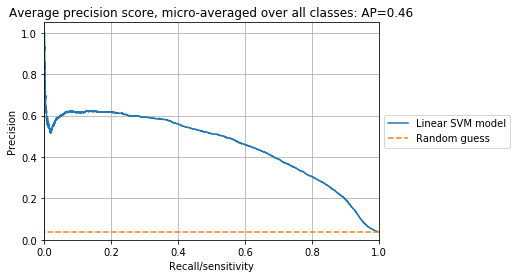

--------------------------------------------------
TN: 176523	 FP: 7770 
FN: 2189	 TP: 5008
The micro averaged sensitivity/recall is: 69.58%
The micro averaged specificity is: 95.78%
The micro averaged precision is: 39.19%
--------------------------------------------------


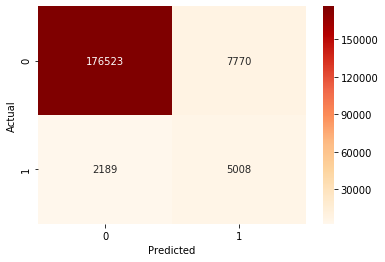

--------------------------------------------------
The macro averaged sensitivity/recall is: 75.23%
The macro averaged specificity is: 95.83%
The macro averaged precision is: 36.81%
--------------------------------------------------


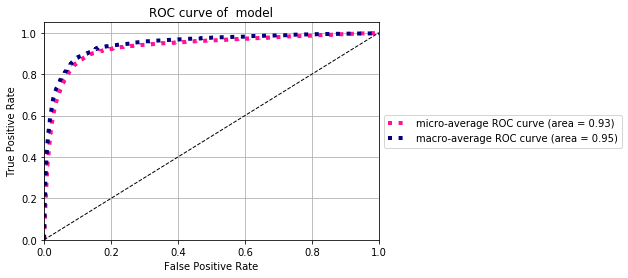

In [88]:
plot_prec_recall(y_test_np, y_scores_linear, y_pred_linear, label_='Linear SVM model')
totals_mat = confusion_matrix(y_test_np.ravel(), y_pred_linear.ravel())
plot_conf_mat(totals_mat)
calc_scores(y_test_np, y_pred_linear)
plot_roc_curve(y_test_np, y_scores_linear, show_all_classes = False)



Training size 15000
Using optimal C: 1.0 and gamma: 0.001
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Test accuracy on rbf kernel 57.34%
micro-averaged scores over all classes
F1 score: 0.369, 
AUC score: 0.921
--------------------
macro-averaged scores over all classes
F1 score: 0.372, 
AUC score: 0.941
--------------------


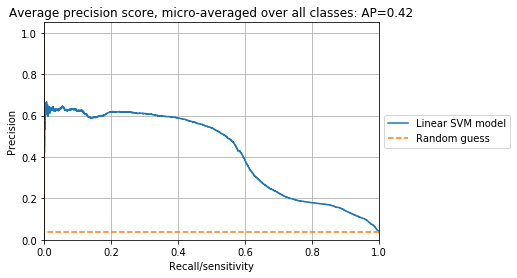

--------------------------------------------------
TN: 170241	 FP: 14052 
FN: 2389	 TP: 4808
The micro averaged sensitivity/recall is: 66.81%
The micro averaged specificity is: 92.38%
The micro averaged precision is: 25.49%
--------------------------------------------------


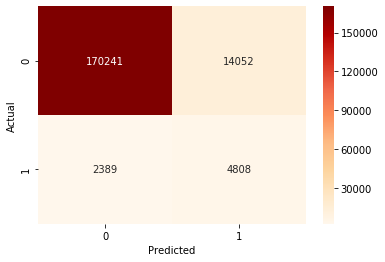

--------------------------------------------------
The macro averaged sensitivity/recall is: 61.74%
The macro averaged specificity is: 92.01%
The macro averaged precision is: 38.80%
--------------------------------------------------


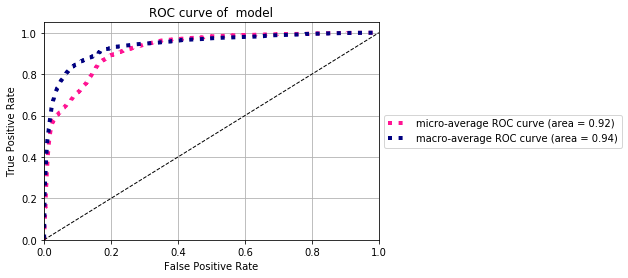

CPU times: user 22min 18s, sys: 6.67 s, total: 22min 25s
Wall time: 22min 18s


In [124]:
%%time
# Tekur ca 8min að keyra á 50þus train size
# Tekur ca 2min að keyra á 15þus train size

print('Training size', train_size)
print('Using optimal C: {} and gamma: {}'.format(rbfOptparam[0], rbfOptparam[1]))

x_test_unrvld = vectorizer.transform(X_test_np.ravel())
clf = OneVsRestClassifier(SVC(C = rbfOptparam[0], gamma = rbfOptparam[1],
                              kernel = 'rbf', class_weight = 'balanced') )
clf.fit(X_train_reduced, y_train_reduced)

y_pred_rbf = clf.predict(vectorizer.transform(X_test_np.ravel()))

test_acc = get_row_accuracy(y_test_np, y_pred_rbf)

print('Test accuracy on rbf kernel {:.2%}'.format(test_acc))

y_scores_rbf = clf.decision_function(vectorizer.transform(X_test_np.ravel()))

plot_prec_recall(y_test_np, y_scores_rbf, y_pred_rbf, label_='Linear SVM model')

totals_mat = confusion_matrix(y_test_np.ravel(), y_pred_rbf.ravel())
plot_conf_mat(totals_mat)
calc_scores(y_test_np, y_pred_rbf)

plot_roc_curve(y_test_np, y_scores_rbf, show_all_classes = False)


In [64]:
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from scipy import interp

def plot_roc_curve(y_true_, y_score_, n_classes = 6, show_all_classes = False, model_name = ''):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_[:, i], y_score_[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_.ravel(), y_score_.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

train_size = 2000
# tekur um 1min+ med 5 þúsund train size
X_train_reduced, y_train_reduced = data_subsample_asserts_two_classes(X_train_np, y_train_np, train_size)
X_train_reduced, vectorizer = vectorize_data(X_train_reduced)
depth_range = range(250, 750, 50)
features_range = np.arange(5, 20, 5).tolist()
features_range.append('sqrt')
features_range.append(300)


    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    if(show_all_classes):
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'crimson', 'indigo', 'limegreen'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=1,
                     label='ROC curve of {} (area = {:0.2f})'
                     ''.format(cols[i+1], roc_auc[i]))
    plt.grid(None) 
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve of {} model'.format(model_name))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    

--------------------------------------------------
TN: 183400	 FP: 893 
FN: 3552	 TP: 3645
The micro averaged sensitivity/recall is: 50.65%
The micro averaged specificity is: 99.52%
The micro averaged precision is: 80.32%
--------------------------------------------------


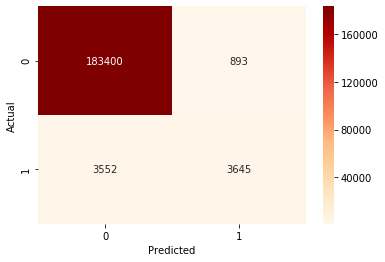

--------------------------------------------------
The macro averaged sensitivity/recall is: 30.30%
The macro averaged specificity is: 99.50%
The macro averaged precision is: 51.65%
--------------------------------------------------


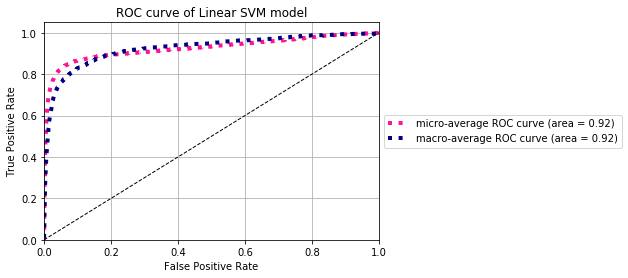

--------------------------------------------------
TN: 183184	 FP: 1109 
FN: 3100	 TP: 4097
The micro averaged sensitivity/recall is: 56.93%
The micro averaged specificity is: 99.40%
The micro averaged precision is: 78.70%
--------------------------------------------------


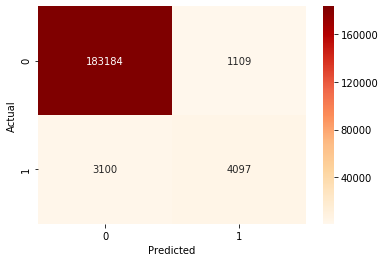

--------------------------------------------------
The macro averaged sensitivity/recall is: 33.82%
The macro averaged specificity is: 99.38%
The macro averaged precision is: 65.91%
--------------------------------------------------


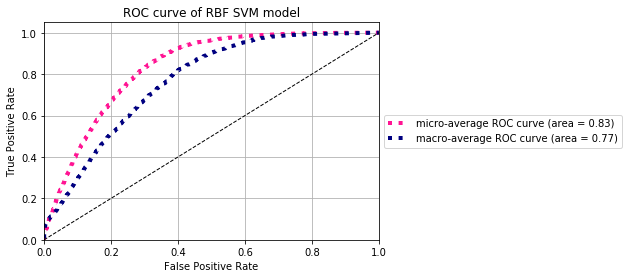

In [77]:
totals_mat = confusion_matrix(y_test_np.ravel(), y_pred_linear.ravel())
plot_conf_mat(totals_mat)
calc_scores(y_test_np, y_pred_linear)
plot_roc_curve(y_test_np, y_scores_linear, show_all_classes = False, model_name = 'Linear SVM')



totals_mat = confusion_matrix(y_test_np.ravel(), y_pred_rbf.ravel())
plot_conf_mat(totals_mat)
calc_scores(y_test_np, y_pred_rbf)
plot_roc_curve(y_test_np, y_scores_rf, show_all_classes = False, model_name = 'RBF SVM')






### Random forrest


Start by finding a optimal number of trees for default values of the random forrest

Data subsampling succsessful!
Training size:  50000
Using max depth: 550 and max features: 5
Test acc 41.94%
Average precision score, micro-averaged over all classes: 0.06


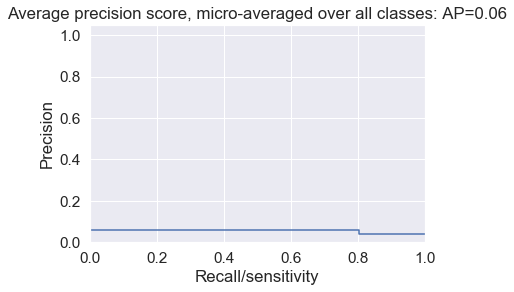

CPU times: user 1min 56s, sys: 1.26 s, total: 1min 58s
Wall time: 1min 8s


In [637]:
%%time
train_size = 50000
#tekur um 1min20 sec með 50þús train size
X_train_reduced, y_train_reduced = data_subsample_asserts_two_classes(X_train_np, y_train_np, train_size)
X_train_reduced, vectorizer = vectorize_data(X_train_reduced)

# Fit and test it
best_max_depth=grid.best_params_['max_depth']
best_max_features=grid.best_params_['max_features']
# Use our best RF model 
auc_scores = []; acc_rf = []
param = np.arange(10, 300, 30).tolist()

for i in param:

    rf = RandomForestClassifier(n_estimators=i, class_weight = 'balanced', n_jobs = -1)
    rf.fit(X_train_reduced, y_train_reduced)
    y_pred_ = rf.predict(vectorizer.transform(X_test_np.ravel()))
    test_acc = get_row_accuracy(y_test_np, y_pred_)
    acc_rf.append(test_acc)
    
    y_proba = rf.predict_proba(vectorizer.transform(X_test_np.ravel()) )
    y_scores_rf = np.zeros(y_test_np.shape)
    for i in range(len(y_proba)):
        y_scores_rf[:,i] = y_proba[i][:,1]
    auc = roc_auc_score(y_test_np, y_scores_rf, average = 'macro')
    auc_scores.append(auc)
    
plt.plot(param, auc_scores,label='AUC ')
plt.plot(param, acc_rf,label='Validation accuracy')
plt.title('title')
plt.xlabel('Number of trees')
plt.legend()
plt.show()
m =np.argmax(auc_scores)
print('Number of trees for highest AUC', param[m])

In [76]:
%%time
warnings.filterwarnings("ignore") # ignore warnings for the purpose of readability

train_size = 3000
# tekur um 1min+ med 5 þúsund train size
X_train_reduced, y_train_reduced = data_subsample_asserts_two_classes(X_train_np, y_train_np, train_size)
X_train_reduced, vectorizer = vectorize_data(X_train_reduced)
depth_range = np.arange(250, 700, 50).tolist()
depth_range.insert(0,100)
depth_range.append(None)
features_range = np.arange(5, 20, 5).tolist()
features_range.append('sqrt')
features_range.append(300)


parameters = {
    'max_depth': depth_range,
    'max_features': features_range
}
rf = RandomForestClassifier(n_estimators=100, oob_score=False, class_weight = 'balanced')
grid = GridSearchCV(rf, parameters, verbose=1, n_jobs=-1, scoring = 'roc_auc') #n_jobs=-1 notar alla kjarna
grid.fit(X_train_reduced, y_train_reduced)
print("Optimal parameters for the grid are {}s with a score of {:.2%}".format(grid.best_params_, grid.best_score_))

Data subsampling succsessful!
Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 275 out of 275 | elapsed:  2.0min finished


Optimal parameters for the grid are {'max_depth': 500, 'max_features': 300}s with a score of 84.07%
CPU times: user 4.35 s, sys: 284 ms, total: 4.64 s
Wall time: 2min 2s


[100, 250, 300, 350, 400, 450, 500, 550, 600, 650, None]
[5, 10, 15, 'sqrt', 300]
[[0.69403777 0.6762881  0.68575313 0.73745488 0.7846128 ]
 [0.71178441 0.74178139 0.77327534 0.82532808 0.82087006]
 [0.72961499 0.75880521 0.77721531 0.83159072 0.83071154]
 [0.73806138 0.77912792 0.80702232 0.82062783 0.82540953]
 [0.770033   0.80502649 0.83580062 0.82407728 0.83865595]
 [0.79342274 0.82140866 0.80178418 0.82337266 0.83040484]
 [0.809253   0.80390776 0.81966578 0.81937534 0.8406726 ]
 [0.82286726 0.80745982 0.81729727 0.83057436 0.81419755]
 [0.80446774 0.81943596 0.82075733 0.83789755 0.82722893]
 [0.80805967 0.80239372 0.81928064 0.8255243  0.83495844]
 [0.80207982 0.81593223 0.81384541 0.82725652 0.82367178]]


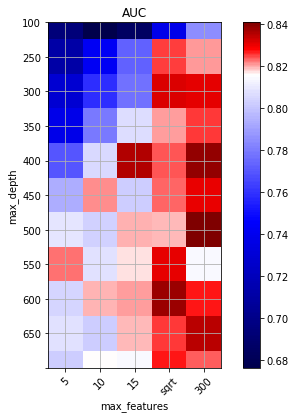

In [80]:
# print(grid.cv_results_)
# print(grid.cv_results_['mean_test_score'])
# sama mynd og að ofan, betra að stilla hér
offset = 0.01

print(depth_range)
print(features_range)
scores = grid.cv_results_['mean_test_score'].reshape(len(depth_range),len(features_range))
print(scores)
plot_heatmap(scores, 'AUC', 'max_features', 'max_depth', 
              features_range, depth_range, np.min(scores), np.median(scores))


Data subsampling succsessful!
Training size:  50000
Using max depth: 250 and max features: sqrt


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   40.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished


Test acc 69.23%


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.0s finished


micro-averaged scores over all classes
F1 score: 0.206, 
AUC score: 0.833
--------------------
macro-averaged scores over all classes
F1 score: 0.139, 
AUC score: 0.767
--------------------


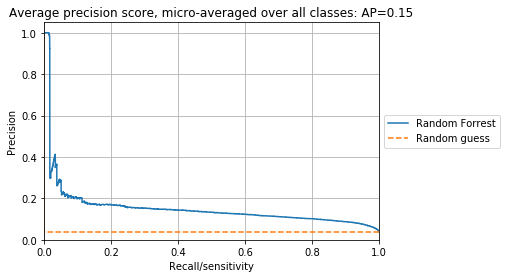

--------------------------------------------------
TN: 156296	 FP: 27997 
FN: 3162	 TP: 4035
The micro averaged sensitivity/recall is: 56.07%
The micro averaged specificity is: 84.81%
The micro averaged precision is: 12.60%
--------------------------------------------------


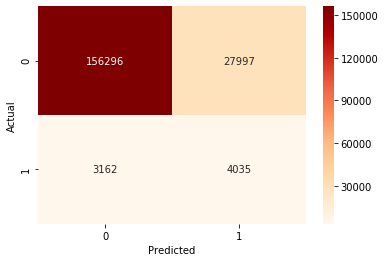

----------------------------------------------------------------------------------------------------
TN: 30313	 FP: 0 
FN: 1602	 TP: 0
The sensitivity/recall is: 0.00%
The specificity is: 100.00%


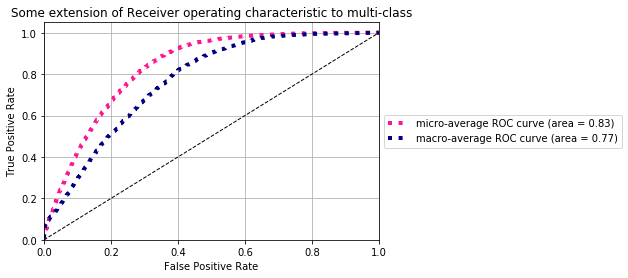

--------------------------------------------------
The macro averaged sensitivity/recall is: 3.36%
The macro averaged specificity is: 14.83%
The macro averaged precision is: 0.27%
--------------------------------------------------
CPU times: user 4min 53s, sys: 3.23 s, total: 4min 57s
Wall time: 50.3 s


In [48]:
%%time
train_size = 50000
#tekur um 1min20 sec með 50þús train size
X_train_reduced, y_train_reduced = data_subsample_asserts_two_classes(X_train_np, y_train_np, train_size)
X_train_reduced, vectorizer = vectorize_data(X_train_reduced)

# Fit and test it
best_max_depth=grid.best_params_['max_depth']
best_max_features=grid.best_params_['max_features']
# Use our best RF model 
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=best_max_depth,
    max_features=best_max_features,
    oob_score=False,
    class_weight = 'balanced',
    n_jobs = -1,
    verbose = 1
)
print('Training size: ', train_size)
print('Using max depth: {} and max features: {}'.format(best_max_depth, best_max_features))
rf.fit(X_train_reduced, y_train_reduced)
y_pred_rf = rf.predict(vectorizer.transform(X_test_np.ravel()))

test_acc = get_row_accuracy(y_test_np, y_pred_rf)
print('Test acc {:.2%}'.format(test_acc))

y_proba = rf.predict_proba(vectorizer.transform(X_test_np.ravel()) )
y_scores_rf = np.zeros(y_test_np.shape)

for i in range(len(y_proba)):
    y_scores_rf[:,i] = y_proba[i][:,1]
    

plot_prec_recall(y_test_np, y_scores_rf, y_pred_rf, label_='Random Forrest')

totals_mat = confusion_matrix(y_test_np.ravel(), y_pred_rf.ravel())
plot_conf_mat(totals_mat)
plot_roc_curve(y_test_np, y_scores_rf, show_all_classes = False)
calc_scores(y_test_np, y_pred_rf)


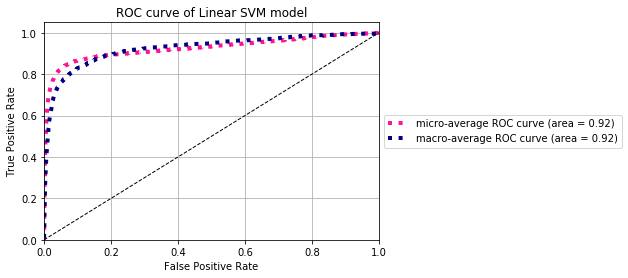

[[184293.      0.]
 [  7197.      0.]]
----------------------------------------------------------------------------------------------------
TN: 184293.0	 FP: 0.0 
FN: 7197.0	 TP: 0.0
Total sensitivity/recall is: 0.00%
Total specificity is: 100.00%


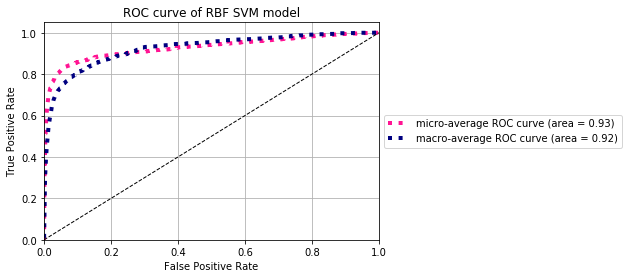

In [73]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
# conmat = multilabel_confusion_matrix(y_test_np, y_test_pred)
conmat = multilabel_confusion_matrix(y_test_np, np.zeros(y_test_np.shape))
total_tn, total_fp, total_fn, total_tp = 0, 0, 0, 0
totals = np.zeros((2,2))
i = 1
for mat in conmat:
    tn, fp, fn, tp  = mat.ravel()
    totals += mat
    print('-'*100)
    print("TN: {}\t FP: {} \nFN: {}\t TP: {}".format(tn, fp, fn, tp))
    print("The sensitivity/recall is: {:.2%}".format(tp/(tp+fn)))
    print("The specificity is: {:.2%}".format(tn/(tn+fp)))
    plot_conf_mat(mat)
    
    i+=1
print(totals) 
print('-'*100)
# Recall = TP / (TP + FN)
# Recall = Sensitivity = True Positive Rate
# Precision = TP / (TP + FP)
# Specificity = TN / (TN + FP) = False Positive Rate
print("TN: {}\t FP: {} \nFN: {}\t TP: {}".format(totals[0,0], totals[0,1], totals[1,0], totals[1,1]))
print("Total recall/sensitivity is: {:.2%}".format(totals[1,1]/(totals[1,1]+totals[1,0])))
print("Total specificity is: {:.2%}".format(totals[1,0]/(totals[1,0]+totals[0,1])))
# plot_heatmap(mat, 'Confusion matrix for total', 'Predicted', 'True Label', 
#               (totals[0,0], totals[0,1]), (totals[1,0],totals[1,1]), np.min(totals), np.median(totals))
plot_conf_mat(totals.astype(int))
# plot_confusion_matrix(rf, vectorizer.transform(X_test_np.ravel()), y_test_np, values_format = 'd')
# print(classification_report(y_test_np, y_test_pred, digits = 3))

(6, 2, 2)


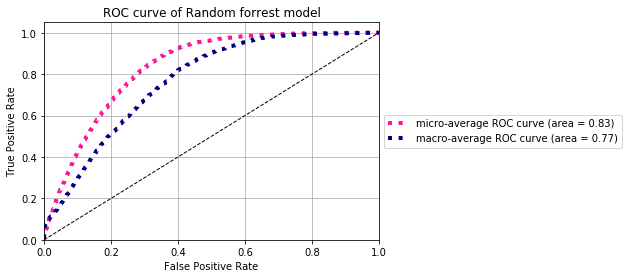

In [600]:
plot_roc_curve(y_test_np, y_scores_linear, show_all_classes = False, model_name = 'Linear SVM')
plot_roc_curve(y_test_np, y_scores_rbf, show_all_classes = False, model_name = 'RBF SVM')
plot_roc_curve(y_test_np, y_scores_rf, show_all_classes = False, model_name = 'Random forrest')
